In [42]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import torch
import torch.nn as nn 
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score#, accuracy_score, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

# set seeds for reproducibility
torch.manual_seed(1234)
np.random.seed(1234)

In [4]:
# load the data
X_train = pd.read_csv("../../Data/X_train.csv")
y_train = pd.read_csv("../../Data/y_train.csv")

print(f"Training Data Shape:")
print(f"X_train: {X_train.shape}")
print(f"y_train: {y_train.shape}")

print(f"\nFirst few rows of X_train:")
X_train.head()

Training Data Shape:
X_train: (400, 9)
y_train: (400, 1)

First few rows of X_train:


,User_ID,Age,Gender,Daily_Screen_Time(hrs),Sleep_Quality(1-10),Stress_Level(1-10),Days_Without_Social_Media,Exercise_Frequency(week),Social_Media_Platform
0,U297,23,Female,5.0,5.0,7.0,2.0,4.0,Instagram
1,U221,23,Other,5.2,7.0,6.0,5.0,1.0,YouTube
2,U001,44,Male,3.1,7.0,6.0,2.0,5.0,Facebook
3,U256,33,Female,5.9,4.0,7.0,0.0,3.0,LinkedIn
4,U336,27,Male,3.8,8.0,6.0,6.0,4.0,Facebook


In [12]:
# data preprocessing

# use label encoder to encode applicable categorical variables
categorical_features = X_train.select_dtypes(include=['object']).columns.tolist()
print(f"Categorical features: {categorical_features}")

X_train_processed = X_train.copy()
label_encoders = {}

for feature in categorical_features:
    if feature != 'User_ID':
        le = LabelEncoder()
        X_train_processed[feature] = le.fit_transform(X_train_processed[feature])
        label_encoders[feature] = le

# drop user id column
if 'User_ID' in X_train_processed.columns:
    X_train_processed = X_train_processed.drop('User_ID', axis=1)

print(f"\nFirst few rows of X_train_processed:")
display(X_train_processed.head())

# convert data into numpy arrays, for compatibility with neural network
X_nn = X_train_processed.values
y_nn = y_train["Happiness_Index(1-10)"].values

print(f"Total training samples: {X_nn.shape[0]}")
print(f"Number of features: {X_nn.shape[1]}")

Categorical features: ['User_ID', 'Gender', 'Social_Media_Platform']

First few rows of X_train_processed:


,Age,Gender,Daily_Screen_Time(hrs),Sleep_Quality(1-10),Stress_Level(1-10),Days_Without_Social_Media,Exercise_Frequency(week),Social_Media_Platform
0,23,0,5.0,5.0,7.0,2.0,4.0,1
1,23,2,5.2,7.0,6.0,5.0,1.0,5
2,44,1,3.1,7.0,6.0,2.0,5.0,0
3,33,0,5.9,4.0,7.0,0.0,3.0,2
4,27,1,3.8,8.0,6.0,6.0,4.0,0


Total training samples: 400
Number of features: 8


In [5]:
# define neural network model

class NeuralNet(nn.Module):

    def __init__(self, input_dim=8, hidden_dim=16):
        super().__init__()
        l1 = nn.Linear(input_dim, hidden_dim)
        a1 = nn.ReLU()
        l2 = nn.Linear(hidden_dim, hidden_dim)
        a2 = nn.ReLU()
        l3 = nn.Linear(hidden_dim,1)
        l = [l1, a1, l2, a2, l3]
        self.module_list = nn.ModuleList(l)

    def forward(self, X):
        for f in self.module_list:
          X = f(X)
        return X

In [39]:
# set hyperparameter grid

param_grid = {
    "hidden_dim": [16, 32, 64],
    "lr": [0.001, 0.01],
    "batch_size": [16, 32],
    "n_epochs": [100, 300]
}

In [28]:
# data preprocessing

# helper functions to encode, standardize, and format data to use in cross-validation folds

def encode_scale(X_train, X_val, categorical_features):
    X_train_processed = X_train.copy()
    X_val_processed = X_val.copy()

    # use label encoder to encode applicable categorical variables
    for feature in categorical_features:
        if feature != 'User_ID':
            le = LabelEncoder()
            X_train_processed[feature] = le.fit_transform(X_train[feature])
            X_val_processed[feature] = le.transform(X_val[feature])
        else:
            # drop user id column
            X_train_processed = X_train_processed.drop('User_ID', axis=1)
            X_val_processed = X_val_processed.drop('User_ID', axis=1)
    
    # scale the data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_processed)
    X_val_scaled = scaler.transform(X_val_processed)
    
    return X_train_scaled, X_val_scaled


def prepare_tensors(X_train, y_train, X_val, y_val, batch_size):

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train.to_numpy(), dtype=torch.float32).reshape(-1,1)
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val.to_numpy(), dtype=torch.float32).reshape(-1,1)

    train_loader = DataLoader(
        TensorDataset(X_train_tensor, y_train_tensor),
                        batch_size = batch_size,
                        shuffle = True
    )

    return train_loader, X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor

In [57]:
# cross-validation and parameter tuning

k = 5
kf = KFold(n_splits = k, shuffle=True, random_state=1234)

results = []

loop = 0
total_loops = math.prod(len(v) for v in param_grid.values())

for hidden_dim in param_grid["hidden_dim"]:
    for lr in param_grid["lr"]:
        for batch_size in param_grid["batch_size"]:
            for n_epochs in param_grid["n_epochs"]:
                fold_mse = []
                fold_r2 = []
                
                loop += 1

                print(f"\n--- Initializing Validation Loop {loop}/{total_loops}. Params: hidden_dim={hidden_dim}, lr={lr}, batch_size={batch_size}, n_epochs={n_epochs} ---\n")
                
                all_val_true = []
                all_val_pred = []
                
                for fold, (train_index, val_index) in enumerate(kf.split(X_train)):

                    X_train_fold, X_val_fold = X_train.iloc[train_index].copy(), X_train.iloc[val_index].copy()
                    y_train_fold, y_val_fold = y_train.iloc[train_index].copy(), y_train.iloc[val_index].copy()

                    categorical_features = X_train_fold.select_dtypes(include=['object']).columns.tolist()
                    X_train_processed, X_val_processed = encode_scale(X_train_fold, X_val_fold, categorical_features)
                    
                    train_loader, X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor = prepare_tensors(X_train_processed, y_train_fold, X_val_processed, y_val_fold, batch_size)


                    model = NeuralNet(input_dim=X_train_processed.shape[1], hidden_dim=hidden_dim)
                    cost_function = nn.MSELoss()
                    optimizer = optim.SGD(model.parameters(), lr=0.001)

                    for epoch in range(n_epochs):
                        model.train()
                        for x_batch, y_batch in train_loader:
                            optimizer.zero_grad()
                            y_pred = model(x_batch)
                            cost = cost_function(y_pred, y_batch)
                            cost.backward()
                            optimizer.step()

                    model.eval()
                    with torch.no_grad():
                        y_pred_tensor = model(X_val_tensor)

                    y_pred = y_pred_tensor.numpy().flatten()
                    y_true = y_val_tensor.numpy().flatten()

                    all_val_true.append(y_true)
                    all_val_pred.append(y_pred)

                    mse = mean_squared_error(y_true, y_pred)
                    r2 = r2_score(y_true, y_pred)

                    fold_mse.append(mse)
                    fold_r2.append(r2)

                    print(f"    Fold {fold+1} of {k} - Validation MSE: {mse:.4f}, Validation R²: {r2:.4f}")
                
                y_true_cv = np.concatenate(all_val_true)
                y_pred_cv = np.concatenate(all_val_pred)

                normalized_mse = 1 / (1 + np.mean(fold_mse))
                normalized_r2 = (np.mean(fold_r2) + 1) / 2
                # calculating a metric that combines mse and r2 score to find the best params
                combined_score = 0.5 * normalized_r2 + 0.5 * normalized_mse

                results.append({
                    "hidden_dim": hidden_dim,
                    "lr": lr,
                    "batch_size": batch_size,
                    "n_epochs": n_epochs,
                    "avg_mse": np.mean(fold_mse),
                    "avg_r2": np.mean(fold_r2),
                    "score": combined_score
                })

                print("\n   --- Overall Neural Network Cross-Validation Results ---")
                print(f"        Average MSE across {k} folds: {np.mean(fold_mse):.4f}")
                print(f"        Lowest MSE across {k} folds: {np.min(fold_mse):.4f}")
                print(f"        Average R² across {k} folds: {np.mean(fold_r2):.4f}")
                print(f"        Lowest R² across {k} folds: {np.min(fold_r2):.4f}")
                print(f"        Highest combined score across {k} folds: {np.min(combined_score)}")



--- Initializing Validation Loop 1/24. Params: hidden_dim=16, lr=0.001, batch_size=16, n_epochs=100 ---

    Fold 1 of 5 - Validation MSE: 0.8495, Validation R²: 0.5816
    Fold 2 of 5 - Validation MSE: 1.1086, Validation R²: 0.5646
    Fold 3 of 5 - Validation MSE: 1.1050, Validation R²: 0.5579
    Fold 4 of 5 - Validation MSE: 0.8581, Validation R²: 0.6433
    Fold 5 of 5 - Validation MSE: 1.2437, Validation R²: 0.3823

   --- Overall Neural Network Cross-Validation Results ---
        Average MSE across 5 folds: 1.0330
        Lowest MSE across 5 folds: 0.8495
        Average R² across 5 folds: 0.5460
        Lowest R² across 5 folds: 0.3823
        Highest combined score across 5 folds: 0.6324329528626039

--- Initializing Validation Loop 2/24. Params: hidden_dim=16, lr=0.001, batch_size=16, n_epochs=300 ---

    Fold 1 of 5 - Validation MSE: 0.7646, Validation R²: 0.6234
    Fold 2 of 5 - Validation MSE: 1.0661, Validation R²: 0.5812
    Fold 3 of 5 - Validation MSE: 1.0316, Vali

In [58]:
results_df = pd.DataFrame(results)

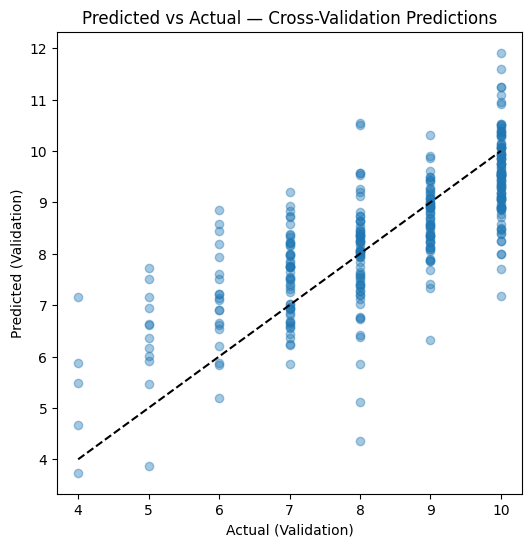

In [67]:
plt.figure(figsize=(6,6))
plt.scatter(y_true_cv, y_pred_cv, alpha=0.4)
plt.plot([y_true_cv.min(), y_true_cv.max()],
         [y_true_cv.min(), y_true_cv.max()],
         'k--')
plt.xlabel("Actual (Validation)")
plt.ylabel("Predicted (Validation)")
plt.title("Predicted vs Actual — Cross-Validation Predictions")
plt.savefig('../../Outputs/nn_predicitons_vs_actual.png', dpi=300, bbox_inches='tight')
plt.show()


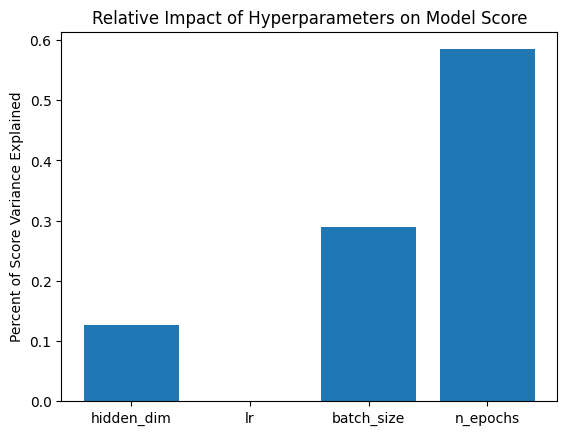

In [66]:
effects = {}
hyperparams = ["hidden_dim", "lr", "batch_size", "n_epochs"]

for param in hyperparams:
    # variance of mean scores across choices of this param
    group_means = results_df.groupby(param)["score"].mean()
    effects[param] = np.var(group_means)

# Normalize to percent
total = sum(effects.values())
effects_norm = {k: v/total for k,v in effects.items()}

plt.bar(effects_norm.keys(), effects_norm.values())
plt.title("Relative Impact of Hyperparameters on Model Score")
plt.ylabel("Percent of Score Variance Explained")
plt.savefig('../../Outputs/nn_relative_parameter_impact.png', dpi=300, bbox_inches='tight')
plt.show()

In [62]:
results_df.sort_values("avg_mse").head(5)

,hidden_dim,lr,batch_size,n_epochs,avg_mse,avg_r2,score
5,16,0.010,16,300,0.940865,0.588510,0.654745
1,16,0.001,16,300,0.948064,0.585651,0.653078
3,16,0.001,32,300,0.952828,0.581865,0.651505
13,32,0.010,16,300,0.977517,0.570888,0.645564
21,64,0.010,16,300,0.987142,0.565483,0.642988


In [63]:
results_df.sort_values("avg_r2").head(5)

,hidden_dim,lr,batch_size,n_epochs,avg_mse,avg_r2,score
22,64,0.010,32,100,1.336772,0.412027,0.566977
18,64,0.001,32,100,1.296286,0.432053,0.575756
10,32,0.001,32,100,1.283570,0.439626,0.578862
14,32,0.010,32,100,1.204230,0.474569,0.595479
2,16,0.001,32,100,1.176712,0.484816,0.600908


In [64]:
best = results_df.loc[results_df["score"].idxmax()]
print("Best Params:")
print(best)

Best Params:
hidden_dim     16.000000
lr              0.010000
batch_size     16.000000
n_epochs      300.000000
avg_mse         0.940865
avg_r2          0.588510
score           0.654745
Name: 5, dtype: float64
